In [40]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

with open("firebase_data.json", "r") as f:
    raw_data = json.load(f)

# JSON to DataFrame
records = []
for entry in raw_data:
    bp_data = entry.get("vitals", {}).get("blood_pressure", [])
    systolic_vals = []
    diastolic_vals = []

    for bp_str in bp_data:
        if isinstance(bp_str, str) and '/' in bp_str:
            try:
                systolic, diastolic = map(int, bp_str.split('/'))
                systolic_vals.append(systolic)
                diastolic_vals.append(diastolic)
            except ValueError:
                continue

    systolic_bp = np.mean(systolic_vals) if systolic_vals else None
    diastolic_bp = np.mean(diastolic_vals) if diastolic_vals else None

    record = {
        "avg_temp": np.mean(entry.get("vitals", {}).get("temperature", [])) if entry.get("vitals", {}).get("temperature") else None,
        "avg_hr": np.mean(entry.get("vitals", {}).get("heart_rate", [])) if entry.get("vitals", {}).get("heart_rate") else None,
        "systolic_bp": systolic_bp,
        "diastolic_bp": diastolic_bp,
        "sleep_quality": entry.get("sleep", {}).get("quality", "").lower(),
        "steps": entry.get("activity", {}).get("steps"),
        "active_minutes": entry.get("activity", {}).get("active_minutes"),
        "sedentary_hours": entry.get("activity", {}).get("sedentary_hours"),
        "calories": entry.get("nutrition", {}).get("calories"),
        "water_oz": entry.get("nutrition", {}).get("water_oz"),
        "protein_g": entry.get("nutrition", {}).get("macros", {}).get("protein_g"),
        "carbs_g": entry.get("nutrition", {}).get("macros", {}).get("carbs_g"),
        "fat_g": entry.get("nutrition", {}).get("macros", {}).get("fat_g"),
    }

    records.append(record) 


df = pd.DataFrame(records)
df.info()
df.describe()

# sleep quality score
sleep_quality_map = {
    "poor": 0,
    "fair": 1,
    "good": 2,
    "excellent": 3
}

# Apply mapping
df["sleep_quality_score"] = df["sleep_quality"].map(sleep_quality_map)
df.drop(columns=["sleep_quality"], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_temp         20 non-null     float64
 1   avg_hr           20 non-null     float64
 2   systolic_bp      20 non-null     float64
 3   diastolic_bp     20 non-null     float64
 4   sleep_quality    20 non-null     object 
 5   steps            20 non-null     int64  
 6   active_minutes   20 non-null     int64  
 7   sedentary_hours  20 non-null     float64
 8   calories         20 non-null     int64  
 9   water_oz         20 non-null     int64  
 10  protein_g        20 non-null     int64  
 11  carbs_g          20 non-null     int64  
 12  fat_g            20 non-null     int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 2.2+ KB


In [42]:
# check if missing value exists
print("Missing values:\n", df.isnull().sum())


Missing values:
 avg_temp               0
avg_hr                 0
systolic_bp            0
diastolic_bp           0
steps                  0
active_minutes         0
sedentary_hours        0
calories               0
water_oz               0
protein_g              0
carbs_g                0
fat_g                  0
sleep_quality_score    0
dtype: int64


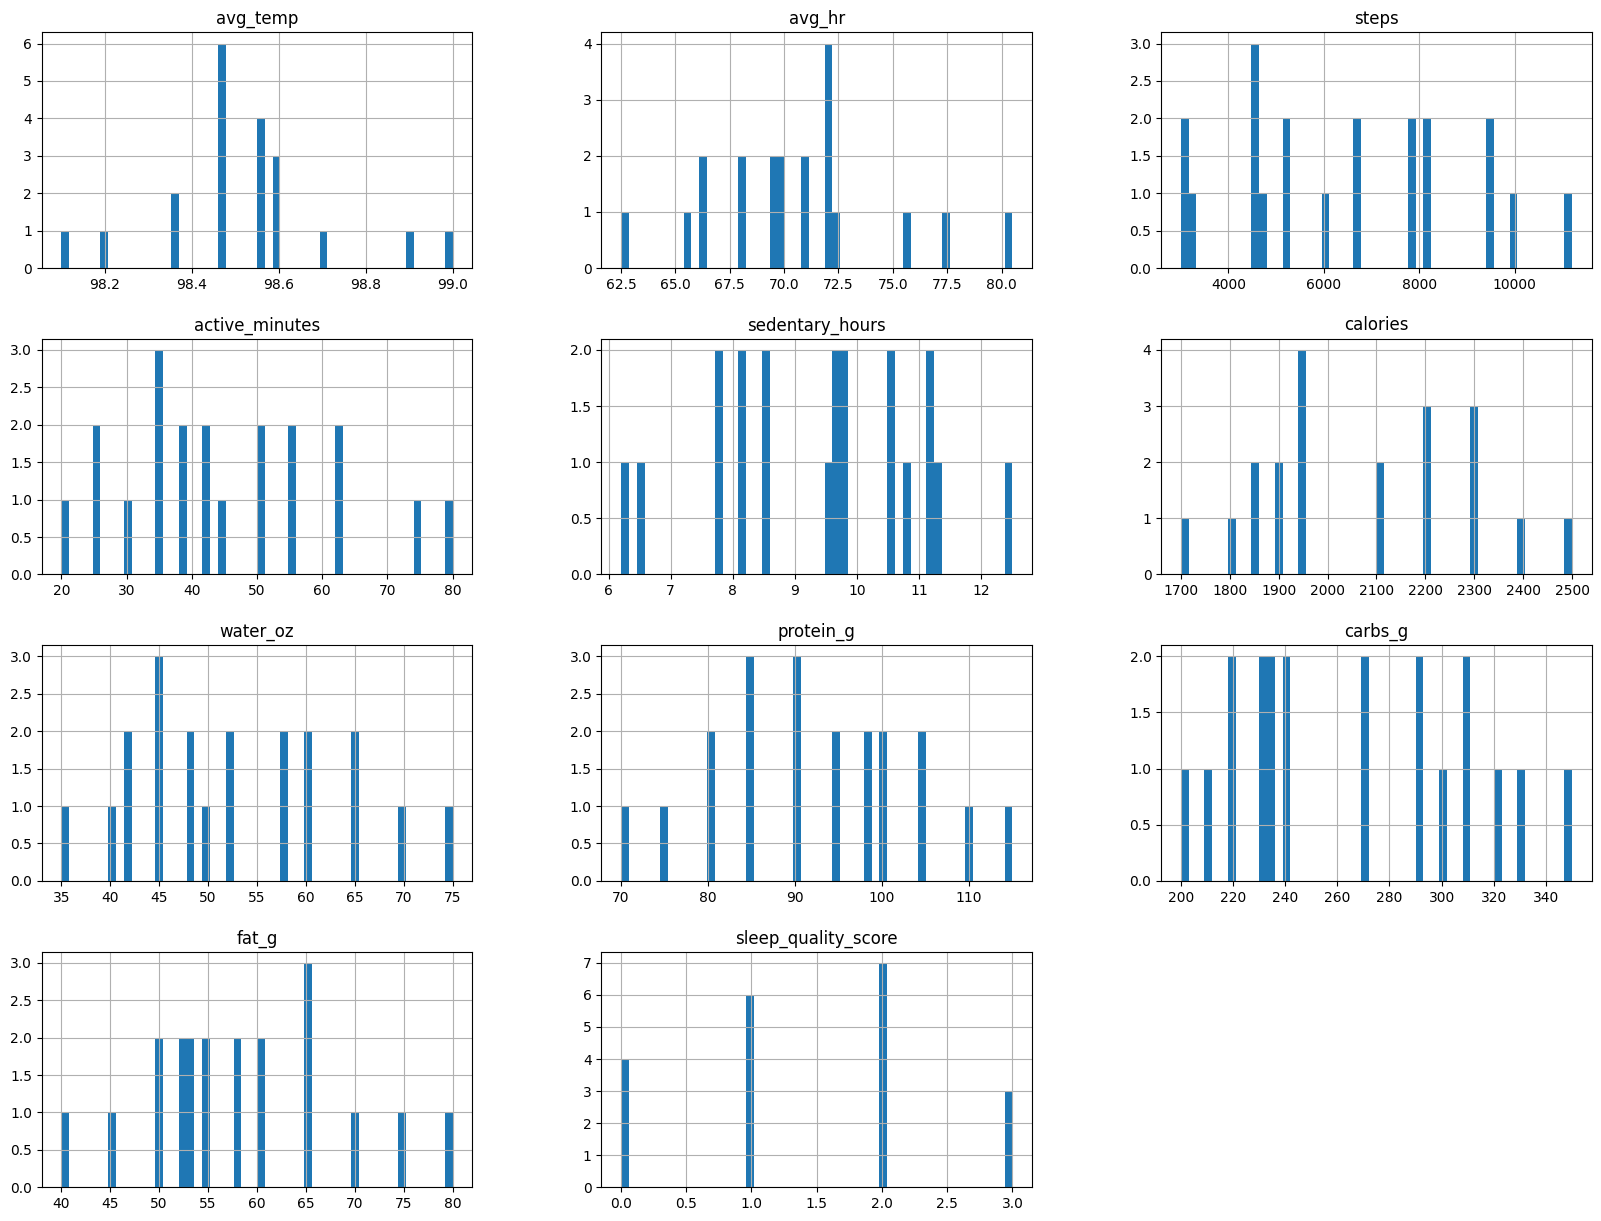

In [95]:
import matplotlib.pyplot as plt
# Plot histograms for numerical columns
df.hist(bins=50, figsize=(20, 15))
plt.show()

In [43]:
def generate_health_score(row):
    score = 0
    
    # Vitals
    if 60 <= row["avg_hr"] <= 80:
        score += 1
    if row["avg_temp"] is not None and 97 <= row["avg_temp"] <= 99:
        score += 1
    if row["systolic_bp"] and row["diastolic_bp"]:
        if 90 <= row["systolic_bp"] <= 120 and 60 <= row["diastolic_bp"] <= 80:
            score += 1

    # Sleep
    score += row["sleep_quality_score"] if not pd.isna(row["sleep_quality_score"]) else 0

    # Activity
    if row["steps"] > df["steps"].median():
        score += 1
    if row["active_minutes"] > df["active_minutes"].median():
        score += 1
    if row["sedentary_hours"] < df["sedentary_hours"].median():
        score += 1

    # Nutrition
    if row["water_oz"] >= 40:
        score += 1

    return score


df["health_score"] = df.apply(generate_health_score, axis=1)
def label_health(score):
    if score >= 7:
        return "Good"
    elif score >= 4:
        return "Moderate"
    else:
        return "Poor"

df["health_label"] = df["health_score"].apply(label_health)
print(df["health_score"].value_counts())
print(df["health_label"].value_counts())


health_score
9.0     7
4.0     3
3.0     3
6.0     3
7.0     2
1.0     1
10.0    1
Name: count, dtype: int64
health_label
Good        10
Moderate     6
Poor         4
Name: count, dtype: int64


In [44]:
# Feature and Target variables
X = df.drop(["health_score", "health_label"], axis=1)
y = df["health_label"]

In [45]:
# Outliers handling
X_imputed = X.fillna(X.mean())
lower_bound = X_imputed.mean() - 3 * X_imputed.std()
upper_bound = X_imputed.mean() + 3 * X_imputed.std()

X_winsorized = X_imputed.apply(
    lambda col: col.clip(lower=lower_bound[col.name], upper=upper_bound[col.name])
)


In [50]:
# Split the data into 70% training data, 30% testing data
X_train, X_test, y_train, y_test = train_test_split(
    X_winsorized, y, test_size=0.3, stratify=y, random_state=42
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Training Target Shape: ", y_train.shape)
print("Testing Target Shape: ", y_test.shape)
print("Missing in training set:\n", X_train.isnull().sum())
# scaling the features
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

X_scaled = scaler.fit_transform(X_winsorized)

print("Scaled Training data: ", X_train_scaler)
print("Scaled test data: ", X_test_scaler)
print(y.value_counts())
print(y_test.value_counts())


Training set size: (14, 13)
Testing set size: (6, 13)
Training Target Shape:  (14,)
Testing Target Shape:  (6,)
Missing in training set:
 avg_temp               0
avg_hr                 0
systolic_bp            0
diastolic_bp           0
steps                  0
active_minutes         0
sedentary_hours        0
calories               0
water_oz               0
protein_g              0
carbs_g                0
fat_g                  0
sleep_quality_score    0
dtype: int64
Scaled Training data:  [[-0.29273973 -0.30082518 -0.08803729 -0.07456967  0.19058364 -0.08796904
   0.12962724 -0.62142615  0.01847037  0.29036236 -0.64697269 -0.37047929
  -0.47519096]
 [-1.42632763 -1.17218088 -1.49663395 -1.84478887  1.44843569  1.75938081
  -1.68515414 -1.68239762  1.56998157  1.4629796  -1.49945435 -1.75977661
   1.42557289]
 [ 0.31765375  0.28007862  0.29932679  0.42472292 -0.64798439 -0.47983113
   0.51458087  0.43954532 -0.58489509 -0.49138246  0.41862939  0.09261982
  -1.42557289]
 [ 0.1432556

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validated Accuracy: 0.86 ± 0.12


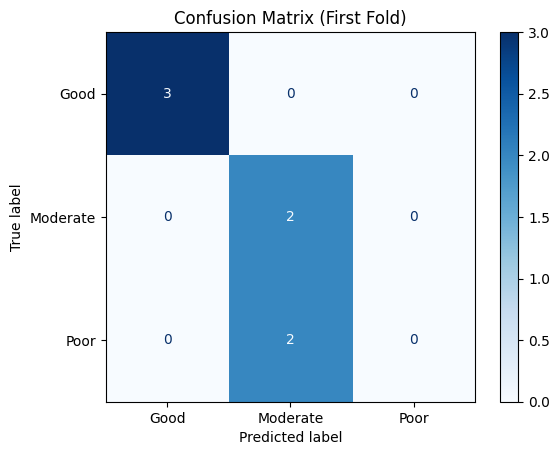

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Use StratifiedKFold to maintain label proportions
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid Search with CV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit on the entire scaled dataset
grid_search.fit(X_scaled, y)

# Best model and its parameters
best_rf = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)

# Cross-validated accuracy
cv_scores = cross_val_score(best_rf, X_scaled, y, cv=cv, scoring='accuracy')
print(f"Cross-validated Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Evaluate using last fold as test (for confusion matrix)
for train_idx, test_idx in cv.split(X_scaled, y):
    X_train_cv, X_test_cv = X_scaled[train_idx], X_scaled[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    break  # Just take the first fold for example

best_rf.fit(X_train_cv, y_train_cv)
y_pred_cv = best_rf.predict(X_test_cv)

# Confusion Matrix
cm = confusion_matrix(y_test_cv, y_pred_cv, labels=best_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (First Fold)")
plt.show()

